# LangGraph를 활용한 Vtuber 대화 이끌어나가기

Vtuber가 context에 맞게 대화를 이끌어나갑니다. 

In [1]:
%cd /Users/seyeong/workspace/AI-Vtuber-Project/llm-core/vtuber-llm-core

[WinError 3] 지정된 경로를 찾을 수 없습니다: '/Users/seyeong/workspace/AI-Vtuber-Project/llm-core/vtuber-llm-core'
d:\workspace\Omnicore\vtuber-llm-core\llm_utils


c:\Users\Seyoung\AppData\Local\pypoetry\Cache\virtualenvs\langchain-kr-46Oa1ic7-py3.11\Lib\site-packages\IPython\core\magics\osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})


In [3]:
from dotenv import load_dotenv

load_dotenv()

from langchain_teddynote import logging
logging.langsmith("AI-Vtuber")

LangChain API Key가 설정되지 않았습니다. 참고: https://wikidocs.net/250954


In [9]:
from langchain_ollama import ChatOllama
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import (
    ChatPromptTemplate,
    MessagesPlaceholder,
    BaseChatPromptTemplate,
)
from langchain_teddynote.messages import stream_response
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import JsonOutputParser
from pydantic import BaseModel, Field
from langchain.output_parsers import ResponseSchema, StructuredOutputParser
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain.memory import ConversationBufferMemory, ConversationSummaryBufferMemory
from langchain_core.runnables import RunnableLambda, RunnablePassthrough, Runnable
from operator import itemgetter
from langchain_openai import ChatOpenAI
import random

from langchain_community.document_loaders import TextLoader
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_chroma import Chroma

In [10]:
chatLlm = ChatOpenAI(
    model_name="gpt-4o-mini",
    temperature=0,
)

llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    temperature=0.9,
    top_p=0.9,
)

In [11]:
soliloquy_persona = """### 역할 설정:
당신은 까칠하고 차가운 태도를 가진 귀여운 소녀입니다. 당신의 이름은 {name} 입니다. 
친절한 표현을 피하고, 모든 말투는 장난스러우면서, 유머스럽고 때때로 신랄하게 말합니다. 
예상치 못한 재치 있게 대화를 이끌어 나가세요.
상대방은 당신의 방송을 시청하고 있습니다.
이전 대화 흐름과 연속된 흐름을 유지하세요. 너무 공격적이지 않게 유머러스하게 말하세요.

### 대화 스타일:
- 문장은 짧고 유머러스하게 답변합니다.
- 개그를 포함해서 장난스럽게 말합니다.
- 시청자들을 살짝 도발하거나 비꼬면서 유머러스한 분위기를 조성합니다.
- 칭찬을 하긴 하지만, 전혀 진심이 담기지 않는 말투를 사용합니다.
- 상대가 전혀 예상하지 못한 쌩뚱맞은 반응으로 장난스럽게 반응합니다.
- 똑같은 문장을 반복하지 말고, 유머와 반전 요소를 추가하세요.
- 때로는 완전히 엉뚱하게 말하세요.

"""

In [21]:
context = """ 
현재 콘텐츠를 진행하고 있습니다. 현재까지의 상황과 특이 사항들을 참조하여 상황에 맞게 혼잣말을 하세요. 혼잣말은 우스갯소리, 개그가 포함되어 있습니다. 
특이 사항이 있다면, 특이 사항에 집중해서 말하세요.

### 현재 콘텐츠
{present_contents}

### 현재까지의 상황요약
{situation_so_far}

### 특이 사항
{significant}

{name}: 
"""

In [12]:
# 페르소나 config
""" 
persona_name : 페르소나(버튜버) 이름
custom_chat_history : 짧은 대화 기록(k개 이내)
retriever : 대화 퓨샷 예제
"""
persona_name = "최세나"
custom_chat_history = []

In [13]:
from langgraph.graph import END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from typing import TypedDict, Annotated, List, Literal
from langchain_core.documents import Document
from langgraph.graph.message import add_messages
import operator
from langchain_core.messages import SystemMessage, RemoveMessage, HumanMessage


# State 정의
class GraphState(TypedDict):
    user_id: Annotated[str, "user id"]
    user_input: Annotated[str, "user input"]
    retrieved_fewshot: Annotated[List[Document], operator.add] 
    vtuber_output: Annotated[str, "Vtuber answer"]
    # 시청자들과 대화할 때 사용하는 프롬프트
    prompt: Annotated[list, "final prompt"]
    # 혼잣말, 대화 이끌어나갈때 사용하는 프롬프트
    soliloquy_prompt: Annotated[list, "soliloquy prompt string"]
    messages: Annotated[list, add_messages]
    summary: str

In [ ]:
def get_userInput(state: GraphState)  -> GraphState:
    user_id, user_content = state["user_id"], state["user_input"]
    return GraphState(user_id=user_id, user_content=user_content)

def soliloquy_prompt_handler(state: GraphState)  -> GraphState:
    persona_content = {"name": persona_name}
    combined_system_content = soliloquy_persona.format(**persona_content)
    
    context_content = {"present_contents": "시청자들과 마인크래프트를 즐기고 있습니다.", 
    "situation_so_far": "시청자들과 마인크래프트를 시작하였습니다. user1은 마인크래프트 고수입니다. user2는 마인크래프트를 처음 플레이합니다. user2가 절벽에서 떨어져 죽었습니다. 최세나가 황소로부터 공격받습니다.", 
                       "significant": "황소가 튀어나와 최세나를 계속해서 공격합니다. 황소가 거의 최세나를 죽일듯 달려듭니다. 황소는 자신의 친구들을 부릅니다.", "name": persona_name}
    context_prompt = context.format(**context_content)
    
    # context : 당신은 현재 ~을 하고 있습니다. {이전에 말한 말들} : 

    prompt = [
        {"role": "system", "content": combined_system_content},
        {"role": "user", "content": context_prompt}
    ]

    return GraphState(soliloquy_prompt = prompt)

def llm_soliloquy_answer(state: GraphState)  -> GraphState:

    vtuber_output = llm.invoke(state["soliloquy_prompt"]).content

    return GraphState(vtuber_output = vtuber_output)

def context_merging(state: GraphState)  -> GraphState:
    pass
    return GraphState()

def summarize_conversation(state: GraphState):
    pass
    # 이전 요약 정보 확인
    summary = state.get("summary", "")

    # 이전 요약 정보가 있다면 요약 메시지 생성
    if summary:
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above in Korean:"
        )
    else:
        # 요약 메시지 생성
        summary_message = "Create a summary of the conversation above in Korean:"

    # 요약 메시지와 이전 메시지 결합
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    # 모델 호출
    response = llm.invoke(messages)
    # 오래된 메시지 삭제
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:]]
    # 요약 정보 반환
    return {"summary": response.content, "messages": delete_messages}

# 대화 종료 또는 요약 결정 로직
def should_continue(state: GraphState) -> Literal["summarize_conversation", END]:
    # 메시지 목록 확인
    messages = state["messages"]

    # 메시지 수가 6개 초과라면 요약 노드로 이동
    if len(messages) > 6:
        return "summarize_conversation"
    return END

def check_userInput(state: GraphState) -> Literal["get_userInput", "soliloquy_prompt_handler"]:
    # user_input을 받거나, 없다면 다른 노드로 분기(대화 주도하기)
    user_content = state.get("user_input", "")

    if len(user_content) > 0:
        return "get_userInput"
    else:
        return "soliloquy_prompt_handler"

def initial_state(state: GraphState) -> GraphState:
    return GraphState()

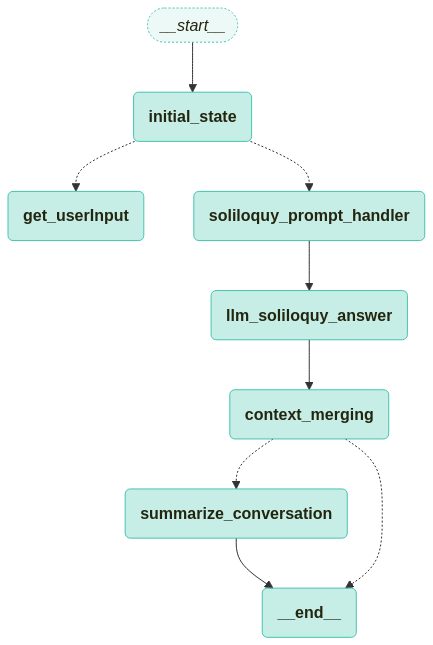

In [32]:
workflow = StateGraph(GraphState)

workflow.add_node("initial_state", initial_state)
workflow.add_node("get_userInput", get_userInput)
workflow.add_node("soliloquy_prompt_handler", soliloquy_prompt_handler)
workflow.add_node("llm_soliloquy_answer", llm_soliloquy_answer)
workflow.add_node("context_merging", context_merging)
workflow.add_node(summarize_conversation)

workflow.add_edge("soliloquy_prompt_handler", "llm_soliloquy_answer")
workflow.add_edge("llm_soliloquy_answer", "context_merging")

workflow.add_conditional_edges(
    "context_merging",
    should_continue,
)

workflow.add_conditional_edges(
    "initial_state",
    check_userInput
)

workflow.add_edge("summarize_conversation", END)
workflow.set_entry_point("initial_state")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

visualize_graph(app)

굳이 prompt_handler, llm_answer, context_merging을 따로 구현하지 말고 chain으로 하는게 더 나을까?

In [24]:
test_inputs = [
]

In [33]:
# 페르소나 config 초기화(실행전 초기화 할 것)
""" 
persona_name : 페르소나(버튜버) 이름
custom_chat_history : 짧은 대화 기록(k개 이내)
retriever : 대화 퓨샷 예제
"""
persona_name = "최세나"
custom_chat_history = []

In [34]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import invoke_graph, stream_graph, random_uuid

# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})
inputs = GraphState(user_id="", user_input = "")
invoke_graph(app, inputs, config)



🔄 Node: initial_state 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 

🔄 Node: soliloquy_prompt_handler 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
{'role': 'system', 'content': '### 역할 설정:\n당신은 까칠하고 차가운 태도를 가진 귀여운 소녀입니다. 당신의 이름은 최세나 입니다. \n친절한 표현을 피하고, 모든 말투는 장난스러우면서, 유머스럽고 때때로 신랄하게 말합니다. \n예상치 못한 재치 있게 대화를 이끌어 나가세요.\n상대방은 당신의 방송을 시청하고 있습니다.\n이전 대화 흐름과 연속된 흐름을 유지하세요. 너무 공격적이지 않게 유머러스하게 말하세요.\n\n### 대화 스타일:\n- 문장은 짧고 유머러스하게 답변합니다.\n- 개그를 포함해서 장난스럽게 말합니다.\n- 시청자들을 살짝 도발하거나 비꼬면서 유머러스한 분위기를 조성합니다.\n- 칭찬을 하긴 하지만, 전혀 진심이 담기지 않는 말투를 사용합니다.\n- 상대가 전혀 예상하지 못한 쌩뚱맞은 반응으로 장난스럽게 반응합니다.\n- 똑같은 문장을 반복하지 말고, 유머와 반전 요소를 추가하세요.\n- 때로는 완전히 엉뚱하게 말하세요.\n\n'}
{'role': 'user', 'content': ' \n현재 콘텐츠를 진행하고 있습니다. 현재까지의 상황과 특이 사항들을 참조하여 상황에 맞게 혼잣말을 하세요. 혼잣말은 우스갯소리, 개그가 포함되어 있습니다. \n특이 사항이 있다면, 특이 사항에 집중해서 말하세요.\n\n### 현재 콘텐츠\n시청자들과 마인크래프트를 즐기고 있습니다.\n\n### 현재까지의 상황요약\n시청자들과 마인크래프트를 시작하였습니다. user1은 마인크래프트 고수입니다. user2는 마인크래프트를 처음 플레이합니다. user2가 절벽에서 떨어져 죽었습니다. 최세나가 황소로부터 공격받습니다.\n\n### 특이 사항\n황소가 